In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

In [52]:
titanic_data = pd.read_csv('https://github.com/Ultraluxe25/Karpov-Stepik-Introduction-to-DS-and-ML/raw/main/csv/titanic.csv')

In [53]:
X = titanic_data.drop(['PassengerId','Survived', 'Name', 'Ticket', 'Cabin'], axis=1) # убираем ненужные колонки
y = titanic_data.Survived

In [57]:
# конвертируем строковые переменные в булевые,
# т.к. дерево решений умеет работать только с числовыми переменными
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [58]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
tree.plot_tree(clf, filled=True, class_names=['Died', 'Servived'], feature_names=list(X)) 
# получаем огромное дереве, т.к. не ограничили его глубину

In [60]:
from sklearn.model_selection import train_test_split

# разбиваем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [61]:
clf.score(X, y) # средняя точность на выбранных метриках

0.9809203142536476

In [62]:
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9781879194630873

In [63]:
clf.score(X_test, y_test) # разница в скорах большая, значит модель переобучилась.

0.7559322033898305

### Глубина дерева

In [67]:
# выясним, как ведут себя значения скоров для трейна и теста при разной глубине дерева

max_depth_values = range(1, 25)
scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train) # предсказываем точность классификации на трэин
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    scores_data = pd.concat([scores_data, temp_score_data])

In [68]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.842282,0.810169


In [69]:
scores_data_long = pd.melt(scores_data,
                           id_vars=['max_depth'],
                           value_vars=['train_score', 'test_score'],
                           var_name='set_type',
                           value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.842282


<Axes: xlabel='max_depth', ylabel='score'>

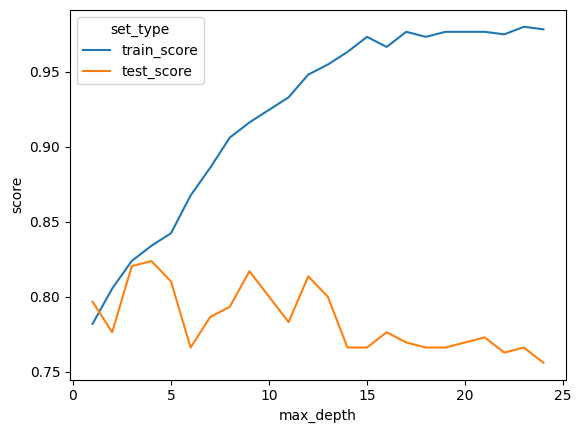

In [70]:
sns.lineplot(x='max_depth', y='score',hue='set_type', data=scores_data_long)

### Кроссвалидация

In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [73]:
# 5 значений - это точность, которую показал классификатор, разбив X_train y_train на 5 равных кусочков
# сначала обучился на первых четырех и предсказал пятый
# потом обучился на всех, кроме 4-го и предсказал 4-й и т.д...
cross_val_score(clf, X_train, y_train, cv=5)

array([0.76666667, 0.82352941, 0.76470588, 0.75630252, 0.80672269])

In [75]:
cross_val_score(clf, X_train, y_train, cv=5).mean() # средняя точность на кросвалидации

0.7835854341736695

In [37]:
# добавим кросвалидация
max_depth_values = range(1, 25)
scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)

    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': mean_cross_val_score})
    scores_data = pd.concat([scores_data, temp_score_data])

In [38]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'], var_name='set_type', value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.842282


In [42]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.783585
202,5,cross_val_score,0.797031
203,6,cross_val_score,0.800392
204,7,cross_val_score,0.797003
205,8,cross_val_score,0.790308
206,9,cross_val_score,0.797003
207,10,cross_val_score,0.785238


<Axes: xlabel='max_depth', ylabel='score'>

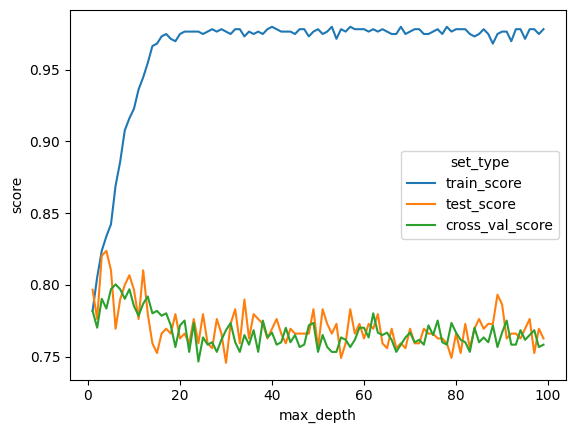

In [40]:
sns.lineplot(x='max_depth', y='score',hue='set_type', data=scores_data_long)

In [43]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [49]:
# cross_val_score(best_clf, X_test, y_test, cv=5).mean()
best_clf.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [50]:
best_clf.score(X_test, y_test)

0.7694915254237288